In [153]:
from google.cloud import bigquery
import pickle as pk
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [144]:
def halfcourt(dataframe):
    #Given a raw shots, reflects them over the origin to turn a full-court chart into a half court one
    #Input: dataframe with at least columns event_coord_x and event_coord_y
    #output: Halfcourt equiv. xs and ys
    xs, ys = dataframe['event_coord_x'].to_numpy(), dataframe['event_coord_y'].to_numpy()
    for i in range(len(xs)):
        if xs[i] >562:
            xs[i] = 1124 - xs[i]

            ys[i] = 600-ys[i]
    return xs, ys

In [233]:
def shot_chart(dataframe, scale = 12):
    #Default scale is 1 foot per resolution element
    
    
    xs, ys = halfcourt(dataframe)
    shot_status = dataframe['shot_made'].to_numpy()
    makes, misses = np.zeros((int(600/scale), int(480/scale))), np.zeros((int(600/scale), int(480/scale)))
    for i in range(len(shot_status)):
        j,k = int(ys[i])//int(scale), int(xs[i])//int(scale)
        #if j>(int(600/scale) or k >int(480/scale)) or j< 0 or k<0:
        if k+1> int(480/scale):
            #Shots with j>int(600/scale) or j<0 or y<0 are out of bounds while shots with k >int(480/scale) are
            #are statisitically unimportant heaves from around halfcourt
            continue

        if shot_status[i]:
            makes[j,k] += 1
        else:
            misses[j,k] += 1
                   
    total = makes + misses
    for i in range(total.shape[0]):
        for j in range(total.shape[1]):
            total[i,j] = max(total[i,j], 1)
    return makes/total, makes, total

In [128]:
path_to_csv = '/project/r/rbond/jorlo/datasets/bball/small_bball.csv'

if os.path.exists(path_to_csv):
    df = pd.read_csv(path_to_csv)


else:
    client = bigquery.Client.from_service_account_json(
            'optimistic-tube-310800-dda5a01f24f6.json')

    query = """
    SELECT 
        event_type,
        season,
        type,
        team_alias,
        team_market,
        team_name,
        player_id,
        player_full_name,
        event_coord_x,
        event_coord_y,
        three_point_shot,
        shot_made

    FROM `bigquery-public-data.ncaa_basketball.mbb_pbp_sr`
    WHERE type = 'fieldgoal'
    AND event_coord_x IS NOT NULL
    AND event_coord_y IS NOT NULL


    """
    query_job = client.query(query)  # Make an API request.

    rows = query_job.result()
    with open(path_to_csv, 'w', newline='') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        header = ['event_type,season,type,team_alias,team_market,team_name,player_id,player_full_name,event_coord_x,event_coord_y,three_point_shot,shot_made']
        spamwriter.writerow(header)
        for row in rows:
            spamwriter.writerow(row)

In [66]:
df.keys()

Index(['event_type', ' season', ' type', ' team_alias', ' team_market',
       ' team_name', ' player_id', ' player_full_name', ' event_coord_x',
       ' event_coord_y', ' three_point_shot', ' shot_made'],
      dtype='object')

In [81]:
#len(df.loc[df['player_full_name']=='Joel Embiid'])

171

In [120]:
xs, ys = df['event_coord_x'].to_numpy(), df['event_coord_y'].to_numpy()

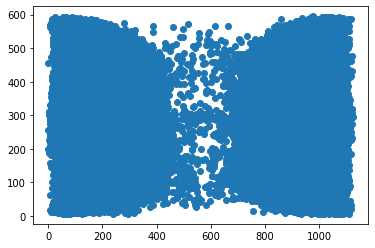

In [121]:
plt.scatter(xs,ys)

We only really care about the half court, so we reflect all points with x> half court about the origin. Note that to preserve the 'handedness' of a shot, we have to reflect about the origin, not half court: shooting from the bottom right is the same as shooting from the top left, not bottom left

In [122]:
#Court runs from apparently 0 to 1124 and ~0-600, so the origin is (300, 562), and we reflect a point if it's >562.
print(min(xs),max(xs), min(ys), max(ys))

0.0 1124.0 6.0 595.0


In [124]:
for i in range(len(xs)):
    if xs[i] >562:
        xs[i] = 1124 - xs[i]

        ys[i] = 600-ys[i]
        

(0.0, 1124.0)

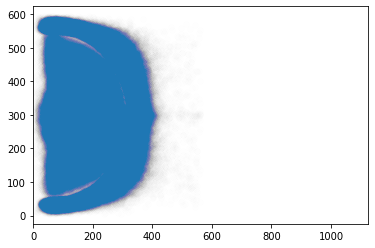

In [125]:
plt.scatter(xs,ys, alpha = 0.005)
plt.xlim(0,1124)

In [140]:
rutgers = df.loc[df['team_alias']=='RUTG']

In [217]:
xs, ys = halfcourt(rutgers)

(0.0, 1124.0)

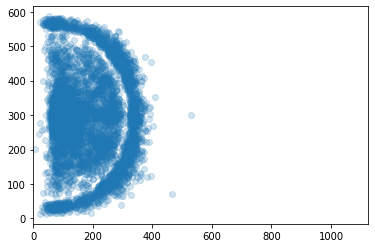

In [218]:
plt.scatter(xs,ys, alpha = 0.2)
plt.xlim(0,1124)

In [248]:
percent, makes, total = shot_chart(rutgers, scale = 12)

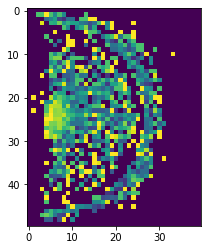

In [249]:
plt.imshow(percent, vmin=0, vmax=0.7)

In [241]:
vil = df.loc[df['team_alias']=='VILL']

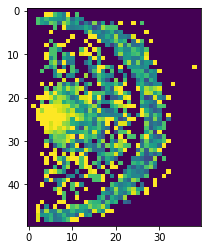

In [250]:
percent, makes, total = shot_chart(vil, scale = 12)
plt.imshow(percent, vmin=0, vmax=0.7)